In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('main_task.xls')
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


None

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [2]:
#самые часто встречающися кухни
def most_common_cuisines(column):
    x = 0
    for i in top_often_cuisine:
        if i in column:
            x += 1
    return x

#самые редкие встречающися кухни
def top_unique_cuisines(column):
    x = 0
    for i in top_unique_cuisine:
        if i in column:
            x += 1
    return x

#Даты из отзывов
def func(x):
    if len(x) == 0:
        return [np.nan]*3
    if len(x) == 1:
        return [x[0],np.nan,np.nan]
    if len(x) == 2:
        return [x[0],x[1],np.nan]
    else:
        return x

#Текст из отзывов
def get_list_rev(x):                         
    x = x.replace('[', '').replace(']', '').replace(
        "'", '').replace(', ', ',').split(',')
    return x

#Положительные отзывы
def reviews_mark(x):
    good_words = ['good','best','wonderful','unique'
                  ,'nice','amazing','excellent ','great','lovely','healthy'
                  ,'delicious','traditional','historic','friendly','fresh'
                  ,'cheap','liked','heavenly','fast','not bad']
    reviews = x[0:2]
    for review in reviews:
        for word in good_words:
            if word in review.lower():
                return 1
    return 0 

In [3]:
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')

In [4]:
df['restaurant_id'] = df['restaurant_id'].apply(lambda x: float(x[3:]))

In [5]:
df['cuisine_style'] = df['cuisine_style'].fillna('Unknown')
df['cuisine_style'] = df['cuisine_style'].replace('[','').replace(']','').replace(' \'','').replace('\'','')
df['cuisine_style'] = df['cuisine_style'].apply(lambda x:x.split(','))
df['count_cuisine_style'] = df['cuisine_style'].apply(lambda x: len(x))

In [6]:
top_often_cuisine = []
top_often_cuisine = df.explode('cuisine_style')['cuisine_style'].value_counts()[
    df.explode('cuisine_style')['cuisine_style'].value_counts() >= 3786].index.tolist()
df['most_common_cuisine'] = df['cuisine_style'].apply(most_common_cuisines)

In [7]:
top_unique_cuisine = []
top_unique_cuisine = df.explode('cuisine_style')['cuisine_style'].value_counts()[
    df.explode('cuisine_style')['cuisine_style'].value_counts() <= 4].index.tolist()
df['top_unique_cuisine'] = df['cuisine_style'].apply(top_unique_cuisines)

In [8]:
df['price_range'] = df['price_range'].replace('$$ - $$$', 2)
df['price_range'] = df['price_range'].replace('$$$$', 3)
df['price_range'] = df['price_range'].replace('$', 1)
df['price_range'] = df['price_range'].fillna(2)

In [9]:
#кол-во отзывов 
df['number_of_reviews'] = df['number_of_reviews'].apply(lambda x: 2000 if x > 2000 else x)
df['number_of_reviews'] = df['number_of_reviews'].fillna(df['number_of_reviews'].mean())

In [10]:
df['reviews'] = df['reviews'].apply(lambda x: x[2:-2])
pattern = re.compile('\d\d.\d\d.\d\d\d\d')
df['reviews_pat'] = df['reviews'].apply(lambda x: pattern.findall(x))
df['reviews_pat'] = df['reviews_pat'].apply(func)

In [11]:
#Кол-во дней между отзывами
df['reviews_razn'] = df['reviews_pat'].apply(lambda x: None if x == [] else pd.to_datetime(x).max() - pd.to_datetime(x).min())

In [12]:
#Кол-во дней между отзывами из datetime в int и заполнение медианой пропуски
y = []
for i in df['reviews_razn']:
    if pd.isnull(i) == False:
        y.append(int(i / np.timedelta64(1, 'D')))
    else:
        y.append(int(df['reviews_razn'].median() / np.timedelta64(1, 'D')))
df['reviews_razn'] = y
#Значение больше 3 лет добавить к трёхлетним
df['reviews_razn'] = df['reviews_razn'].apply(lambda x: 1095 if x > 1095 else x)

In [13]:
df['id_ta'] = df['id_ta'].apply(lambda x: int(x[1:]))

In [14]:
df['reviews'] = df['reviews'].apply(get_list_rev)
df['reviews_mark'] = df['reviews'].apply(reviews_mark)

In [15]:
#Численость населения
population = {
    'London' : 8909081,
    'Paris' : 2148271,
    'Madrid' : 3223334,
    'Barcelona' : 1620343,
    'Berlin' : 3769495,
    'Milan' : 1399860,
    'Rome' : 2860009,
    'Prague' : 1324277,
    'Lisbon' : 505526,
    'Vienna' : 2600000,
    'Amsterdam' : 872680,
    'Brussels' : 1208542,
    'Hamburg' : 1845229,
    'Munich' : 1484226,
    'Lyon' : 516092,
    'Stockholm' : 975904,
    'Budapest' : 1752286,
    'Warsaw' : 1793579,
    'Dublin' : 554554,
    'Copenhagen' : 794128,
    'Athens' : 664046,
    'Edinburgh' : 488050, 
    'Zurich' : 415215,
    'Oporto' : 287591,
    'Geneva' : 201818, 
    'Krakow' : 779115, 
    'Oslo' : 697549, 
    'Helsinki' : 656229,
    'Bratislava' : 437726,
    'Luxembourg' : 626108,
    'Ljubljana' : 295504
}

df['population'] = df['city'].map(population)

In [16]:
#индекс покупательской способности 
purchasing_power_index = {
    'London' : 24,
    'Paris' : 22,
    'Madrid' : 23,
    'Barcelona' : 30,
    'Berlin' : 8,
    'Milan' : 40,
    'Rome' : 37,
    'Prague' : 31,
    'Lisbon' : 48,
    'Vienna' : 21,
    'Amsterdam' : 19,
    'Brussels' : 15,
    'Hamburg' : 7,
    'Munich' : 6,
    'Lyon' : 70,
    'Stockholm' : 13,
    'Budapest' : 51,
    'Warsaw' : 29,
    'Dublin' : 27,
    'Copenhagen' : 10,
    'Athens' : 53,
    'Edinburgh' : 16, 
    'Zurich' : 2,
    'Oporto' : 42,
    'Geneva' : 3, 
    'Krakow' : 36, 
    'Oslo' : 17, 
    'Helsinki' : 9,
    'Bratislava' : 39,
    'Luxembourg' : 4,
    'Ljubljana' : 32
}

df['purchasing_power'] = df['city'].map(purchasing_power_index)

In [17]:
#количество ресторанов в городах
res_count = {
    'Paris': 17593,
    'Stockholm': 3131,
    'London': 22366,
    'Berlin': 8110, 
    'Munich': 3367,
    'Oporto': 2060, 
    'Milan': 7940,
    'Bratislava': 1331,
    'Vienna': 4387, 
    'Rome': 12086,
    'Barcelona': 10086,
    'Madrid': 11562,
    'Dublin': 2706,
    'Brussels': 3703,
    'Zurich': 1901,
    'Warsaw': 3210,
    'Budapest': 3445, 
    'Copenhagen': 2637,
    'Amsterdam': 4189,
    'Lyon': 2833,
    'Hamburg': 3501, 
    'Lisbon': 4985,
    'Prague': 5850,
    'Oslo': 1441, 
    'Helsinki': 1661,
    'Edinburgh': 2248,
    'Geneva': 1753,
    'Ljubljana': 647,
    'Athens': 2814,
    'Luxembourg': 759,
    'Krakow': 1832       
}
df['restaurants_count'] = df['city'].map(res_count)

In [18]:
#Является ли столицей
capital = ['London', 'Paris', 'Madrid', 'Berlin', 'Rome', 'Prague',
          'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Stockholm',
          'Budapest', 'Warsaw', 'Dublin', 'Copenhagen', 'Athens',
          'Edinburgh', 'Oslo', 'Helsinki', 'Bratislava',
          'Luxembourg', 'Ljubljana']
df['is_capital'] = df['city'].apply(lambda x: 1 if x in capital else 0)

In [19]:
#кол-во ресторанов в городе
number_of_rest_city = df.groupby('city')['ranking'].count().to_dict()
df['rest_city_count'] = df['city'].map(number_of_rest_city)

In [20]:
#ранг ресторана по городу
df['city_ranking'] = df['ranking'] / df.rest_city_count

In [21]:
# ранг ресторана на основании кол-ва отзывов
df['ranking_rev_count'] = df['ranking'] * df['number_of_reviews']

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,...,reviews_pat,reviews_razn,reviews_mark,population,purchasing_power,restaurants_count,is_capital,rest_city_count,city_ranking,ranking_rev_count
0,5569.0,Paris,"[['European', 'French', 'International']]",5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,1912643,...,"[12/31/2017, 11/20/2017, nan]",41,1,2148271,22,17593,1,4897,1.137431,1080580.0
1,1535.0,Stockholm,[Unknown],1537.0,4.0,2.0,10.0,"[Unique cuisine, Delicious Nepalese food, 07/0...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,7992032,...,"[07/06/2017, 06/19/2016, nan]",382,1,975904,13,3131,1,820,1.874390,15370.0
2,352.0,London,"[['Japanese', 'Sushi', 'Asian', 'Grill', '...",353.0,4.5,3.0,688.0,"[Catch up with friends, Not exceptional, 01/08...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,8632781,...,"[01/08/2018, 01/06/2018, nan]",2,0,8909081,24,22366,1,5757,0.061317,242864.0
3,3456.0,Berlin,[Unknown],3458.0,5.0,2.0,3.0,"[, ]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,1358776,...,"[nan, nan, nan]",49,0,3769495,8,8110,1,2155,1.604640,10374.0
4,615.0,Munich,"[['German', 'Central European', 'Vegetarian ...",621.0,4.0,2.0,84.0,"[Best place to try a Bavarian food, Nice build...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,6864963,...,"[11/18/2017, 02/19/2017, nan]",272,1,1484226,6,3367,0,893,0.695409,52164.0


AxesSubplot(0.125,0.125;0.62x0.755)


,restaurant_id,ranking,rating,price_range,number_of_reviews,id_ta,count_cuisine_style,most_common_cuisine,top_unique_cuisine,reviews_razn,reviews_mark,population,purchasing_power,restaurants_count,is_capital,rest_city_count,city_ranking,ranking_rev_count
restaurant_id,1.000000,1.000000,-0.368308,-0.026516,-0.244004,0.048820,-0.320270,-0.247299,-0.001430,0.080052,-0.147050,0.563412,-0.064670,0.701460,0.202283,0.709094,0.553090,0.298613
ranking,1.000000,1.000000,-0.368371,-0.026525,-0.244041,0.048826,-0.320250,-0.247304,-0.001425,0.080040,-0.147021,0.563682,-0.064811,0.701494,0.202251,0.709115,0.553154,0.298603
rating,-0.368308,-0.368371,1.000000,-0.028588,0.030512,0.159111,0.120059,0.086703,0.011337,-0.075471,0.129541,-0.024039,0.017384,-0.047694,0.020758,-0.061376,-0.542702,-0.244638
price_range,-0.026516,-0.026525,-0.028588,1.000000,0.126090,-0.056380,0.003177,0.136718,-0.010794,-0.038228,-0.061978,-0.016766,-0.067663,-0.004684,-0.008270,0.006220,-0.046487,0.041741
number_of_reviews,-0.244004,-0.244041,0.030512,0.126090,1.000000,-0.312579,0.448756,0.318690,-0.007808,-0.140950,0.119727,0.020321,0.075343,0.049500,0.014398,0.028854,-0.443342,0.342156
id_ta,0.048820,0.048826,0.159111,-0.056380,-0.312579,1.000000,-0.220633,-0.077265,0.014524,-0.178280,-0.150630,-0.042222,0.067651,-0.058432,-0.005756,-0.058442,0.168365,-0.212162
count_cuisine_style,-0.320270,-0.320250,0.120059,0.003177,0.448756,-0.220633,1.000000,0.503857,0.029934,-0.155164,0.233553,0.045643,0.009965,-0.004885,0.043107,-0.023936,-0.540307,0.112159
most_common_cuisine,-0.247299,-0.247304,0.086703,0.136718,0.318690,-0.077265,0.503857,1.000000,-0.033536,-0.132572,0.108803,-0.018301,-0.015106,-0.045124,-0.028859,-0.066101,-0.347367,0.056535
top_unique_cuisine,-0.001430,-0.001425,0.011337,-0.010794,-0.007808,0.014524,0.029934,-0.033536,1.000000,-0.005491,0.005868,0.011202,-0.011286,0.004021,0.008097,0.004761,-0.011294,-0.006586
reviews_razn,0.080052,0.080040,-0.075471,-0.038228,-0.140950,-0.178280,-0.155164,-0.132572,-0.005491,1.000000,0.101732,-0.032189,-0.020245,-0.018495,-0.017121,-0.014498,0.141989,-0.062075


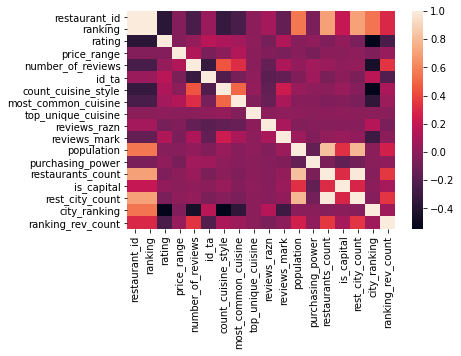

In [22]:
display(df.head())
print(sns.heatmap(df.corr()))
df.corr()

In [23]:
y = df['rating']
X = df.drop(['rating', 'city', 'cuisine_style', 'reviews', 'url_ta', 'id_ta', 'reviews_pat'], axis=1)
display(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurant_id        40000 non-null  float64
 1   ranking              40000 non-null  float64
 2   price_range          40000 non-null  float64
 3   number_of_reviews    40000 non-null  float64
 4   count_cuisine_style  40000 non-null  int64  
 5   most_common_cuisine  40000 non-null  int64  
 6   top_unique_cuisine   40000 non-null  int64  
 7   reviews_razn         40000 non-null  int64  
 8   reviews_mark         40000 non-null  int64  
 9   population           40000 non-null  int64  
 10  purchasing_power     40000 non-null  int64  
 11  restaurants_count    40000 non-null  int64  
 12  is_capital           40000 non-null  int64  
 13  rest_city_count      40000 non-null  int64  
 14  city_ranking         40000 non-null  float64
 15  ranking_rev_count    40000 non-null 

None

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2080475
